<a href="https://colab.research.google.com/github/ALejandroCh17/Tennis-Ball-Robot/blob/daniel_branch/model2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/My Drive/capstone_dataset_2/Tennis.v1i.yolov8.zip" -d "/content/drive/My Drive/capstone_dataset_3"

#Import Dependencies

In [27]:
import os
from PIL import Image
import tensorflow as tf

#Load the Dataset


In [25]:
# Base directory where train, test, and valid folders are located
base_dir = '/content/drive/My Drive/capstone_dataset_3'

image_folders = ['train/images', 'test/images', 'valid/images']
label_folders = ['train/labels', 'test/labels', 'valid/labels']

In [6]:
# Dictionary to hold data associations for each dataset split
data_associations = {
    'train': {},
    'test': {},
    'valid': {}
}

In [7]:
# Function to associate images with labels within a specific folder
def associate_images_with_labels(image_folder, label_folder):
    associations = {}
    for image_file in os.listdir(image_folder):
        if image_file.endswith('.jpg'):  # Confirm it's an image file
            # Construct the label filename by changing the extension
            label_file = image_file.replace('.jpg', '.txt')
            # Build the full path to the label file
            label_file_path = os.path.join(label_folder, label_file)
            # Check if the corresponding label file exists
            if os.path.exists(label_file_path):
                # Save the association
                associations[image_file] = label_file
            else:
                print(f"Warning: Label file for {image_file} not found.")
    return associations

In [8]:
# Iterate through each dataset split and populate data associations
for split in ['train', 'test', 'valid']:
    print(f"Processing {split} data...")
    # Construct paths to the image and label folders for the current split
    image_folder = os.path.join(base_dir, split, 'images')
    label_folder = os.path.join(base_dir, split, 'labels')
    # Perform association and save the results
    data_associations[split] = associate_images_with_labels(image_folder, label_folder)

Processing train data...
Processing test data...
Processing valid data...


#Exploratory Data Analysis

In [11]:
print(len(data_associations['train']))
print(len(data_associations['test']))
print(len(data_associations['valid']))

2361
120
183


Observation: Data split isn't even

In [21]:
def get_image_dimensions(image_folder):
    dimensions = set()  # Initialize an empty set to store unique dimensions
    for image_filename in os.listdir(image_folder):
        if image_filename.lower().endswith(('.png', '.jpg', '.jpeg')):  # Check for image file extensions
            image_path = os.path.join(image_folder, image_filename)
            with Image.open(image_path) as img:
                dimensions.add(img.size)  # Add the image size to the set
    return dimensions  # Return the set of unique dimensions

In [22]:
# Function to check if all images share the same dimensions across all folders
def check_shared_dimensions(base_dir, image_folders):
    shared_dimensions = None
    for folder in image_folders:
        folder_path = os.path.join(base_dir, folder)
        dims = get_image_dimensions(folder_path)
        if shared_dimensions is None:
            shared_dimensions = dims  # Set the initial shared dimensions
        else:
            # Ensure shared_dimensions is a set before intersection
            shared_dimensions = shared_dimensions.intersection(dims)
            # Break if there are no common dimensions
            if not shared_dimensions:
                break
    return shared_dimensions

In [23]:
# Use the function to check for shared dimensions
shared_dims = check_shared_dimensions(base_dir, image_folders)
if shared_dims and len(shared_dims) == 1:
    shared_dim = shared_dims.pop()  # Get the single shared dimension
    print(f"All images share the same dimensions: {shared_dim}")
else:
    print("Not all images share the same dimensions.")

All images share the same dimensions: (640, 640)


Observation: All images share the same dimensions.

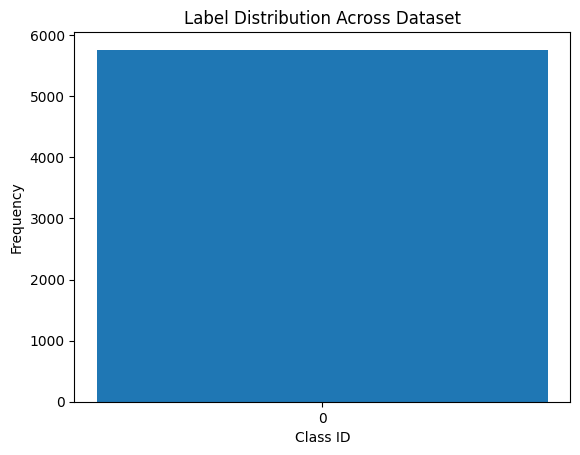

In [26]:
import matplotlib.pyplot as plt
from collections import Counter

# Function to count the occurrence of each label
def count_labels(label_folder):
    label_counts = Counter()
    for label_file in os.listdir(label_folder):
        label_path = os.path.join(label_folder, label_file)
        with open(label_path, 'r') as file:
            for line in file:
                class_id = line.split()[0]  # Assuming class_id is the first element
                label_counts[class_id] += 1
    return label_counts

# Aggregate label counts for all label folders
total_label_counts = Counter()
for folder in label_folders:
    folder_path = os.path.join(base_dir, folder)
    total_label_counts.update(count_labels(folder_path))

# Sorting the label counts dictionary for consistent plotting
sorted_label_counts = dict(sorted(total_label_counts.items()))

# Plotting the label distribution
plt.bar(sorted_label_counts.keys(), sorted_label_counts.values())
plt.xlabel('Class ID')
plt.ylabel('Frequency')
plt.title('Label Distribution Across Dataset')
plt.show()

Observation: Falls in line with approach. Our approach is training a model specifically to detect balls and to discern between scenes with and without balls.

#Data Preprocessing

#Split the dataset

In [28]:
def get_file_paths(base_dir, image_folders, label_folders):
    image_paths = []
    label_paths = []

    for img_folder, lbl_folder in zip(image_folders, label_folders):
        img_dir = os.path.join(base_dir, img_folder)
        lbl_dir = os.path.join(base_dir, lbl_folder)

        # Assuming filenames without extensions match between images and labels
        img_files = [os.path.join(img_dir, f) for f in os.listdir(img_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
        lbl_files = [os.path.join(lbl_dir, f.replace('.png', '.txt').replace('.jpg', '.txt').replace('.jpeg', '.txt')) for f in os.listdir(img_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]

        image_paths.extend(img_files)
        label_paths.extend(lbl_files)

    return image_paths, label_paths

# Base directory where train, test, and valid folders are located
base_dir = '/content/drive/My Drive/capstone_dataset_3'

# Define your image and label folders
image_folders = ['train/images', 'test/images', 'valid/images']
label_folders = ['train/labels', 'test/labels', 'valid/labels']

# Get all file paths
image_paths, label_paths = get_file_paths(base_dir, image_folders, label_folders)


In [32]:
# Create a TensorFlow dataset from paths and labels
dataset = tf.data.Dataset.from_tensor_slices((image_paths, label_paths))

In [42]:
def load_and_preprocess_image(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [256, 256])
    image /= 255.0  # Normalize to [0,1]
    label = tf.strings.to_number(label, out_type=tf.int32)  # Convert labels to integers
    return image, label

In [33]:
dataset = dataset.map(load_and_preprocess_image)

In [35]:
# Define sizes of each dataset split
total_size = len(dataset)
train_size = int(0.7 * total_size)
val_size = int(0.2 * total_size)
test_size = total_size - train_size - val_size

# Split the dataset correctly
train_dataset = dataset.take(train_size)

# Skip over the training dataset to start the validation dataset
remaining_dataset = dataset.skip(train_size)
val_dataset = remaining_dataset.take(val_size)

# Skip over the validation dataset to get the testing dataset
test_dataset = remaining_dataset.skip(val_size)

#Model Architecture

In [36]:
import tensorflow as tf
from tensorflow.keras import layers, models

def create_model():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(1, activation='sigmoid')  # Use 'softmax' for multi-class classification
    ])
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',  # Use 'categorical_crossentropy' for multi-class classification
                  metrics=['accuracy'])
    return model


In [37]:
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        36928     
                                                                 
 flatten (Flatten)           (None, 230400)            0

In [38]:
checkpoint_path = "training_1/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1,
                                                 save_freq='epoch')

# This may generate warnings related to saving the state of the optimizer.
# These warnings (and similar warnings throughout this notebook)
# are in place to discourage outdated usage, and can be ignored.

In [40]:
BATCH_SIZE = 32

train_dataset = train_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

# Additionally, ensure your datasets are prefetched for optimal performance
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

In [43]:
EPOCHS = 10
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=[cp_callback]
)

Epoch 1/10
53/59 [=========================>....] - ETA: 0s

ValueError: Unexpected result of `train_function` (Empty logs). This could be due to issues in input pipeline that resulted in an empty dataset. Otherwise, please use `Model.compile(..., run_eagerly=True)`, or `tf.config.run_functions_eagerly(True)` for more information of where went wrong, or file a issue/bug to `tf.keras`.

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset, verbose=2)
print('\nTest accuracy:', test_acc)